# Diffusion as a Stochastic Process

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [804]:
X = np.zeros((102,102))

In [805]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [806]:
X.shape

(102, 102)

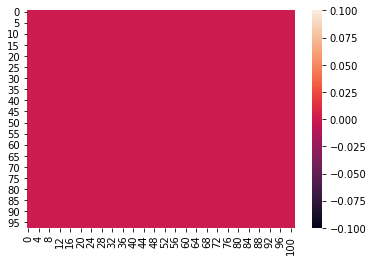

In [807]:
sns.heatmap(X[1:100][1:100])

In [808]:
for i in range(400):
    i,j = np.random.randint(1,101), np.random.randint(1,101)
    X[i][j] = X[i][j] + 1

### Distribucion uniforme

In [809]:
def dist_uni(X):
    for i in range(400):
        i,j = np.random.randint(1,101), np.random.randint(1,101)
        X[i][j] = X[i][j] + 1
    return X

In [810]:
X = dist_uni(X)

In [811]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

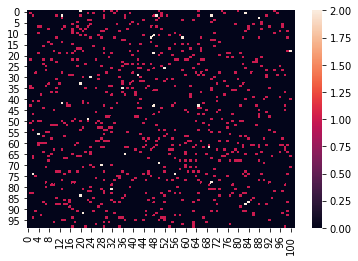

In [812]:
sns.heatmap(X[1:101][1:101])

### Actualización de Condiciones Periódicas

In [813]:
for j in range(1,101):
    X[0][j] = X[100][j]
    X[101][j] = X[1][j]
    X[j][0] = X[j][100]
    X[j][101] = X[j][1]

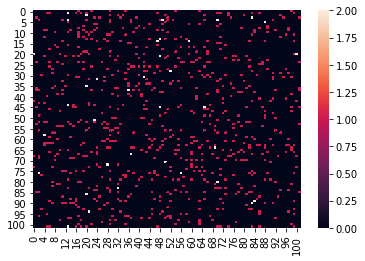

In [814]:
sns.heatmap(X[:][:])

### Ley de Fick

El flujo de partículas es proporcional al gradiente de concentración

$$J(\mathbf{x},t) = - D \nabla c(\mathbf{x}, t)$$

Número de partículas que cruzan, por unidad de área, por unidad de tiempo. Entonces $A J$ es el número de partículas por unidad de tiempo que están atravesando la "ventana" de tamaño $A$.

Para implementar el algoritmo, debemos calcular la probabilidades por unidad de tiempo de moverse las partículas a regiones contiguas. Para ello, usamos una versión discreta de la ley de Fick

$$a(s,d,i,j) =  - A D \frac{\left [X(s,i + 1,j)/L^3 - X(s, i,j)/L^3 \right ]}{L}$$

$$[D] = \frac{L^2}{s}$$

en donde $d$ indica la dirección en la que se movería la partícula, en este caso a la derecha; cada partícula tiene 4 grados de libertad. Esto es, aquí la clave de poder considerar la difusión como un procesos análogo a las reacciones químicas (desde el punto de vista probabilístico), es que cada posibilidad de movimiento es análogo o equivalente a la posibilidad de una transmutación química.


En un espacio de dos dimensiones, hay 4 posibilidades para cada molécula o partícula; hay que ponderarlas todas

In [815]:
D = 1.

In [70]:
a = np.zeros((4,101,101))

### Cálculo de las "propensiones" $a(s,d,i,j)$

In [819]:
for i in range(1,101):
    for j in range(1,101):
        a[0][i][j] = D*(X[i][j] - X[i - 1][j])
        if a[0][i][j] < 0:
            a[0][i][j] = 0
        a[1][i][j] = D*(X[i][j] - X[i + 1][j])
        if a[1][i][j] < 0:
            a[1][i][j] = 0
        a[2][i][j] = D*(X[i][j] - X[i][j - 1])
        if a[2][i][j] < 0:
            a[2][i][j] = 0
        a[3][i][j] = D*(X[i][j] - X[i - 1][j + 1])
        if a[3][i][j] < 0:
            a[3][i][j] = 0

### Rutina Montecarlo para el algoritmo de Gillespie

$$P(\tau, \mu, i, j) = a(\mu, i, j)\, \exp{-[\sum_{\mu i j} a(\mu, i ,j)] \tau ]}$$

$$P(\tau, \mu, i, j) = P_1(\tau) P_2(\mu, i, j| \tau)$$

$$P_1(\tau)= \exp{-[\sum_{\mu i j} a(\mu, i ,j)] \tau ]}  \sum_{\mu i j} a(\mu, i, j)$$

$$P_2(\mu, i, j| \tau) = \frac{a( \mu, i, j)}{\sum_{\mu i j} a(\mu, i, j)}$$

$$P_3(\mu |\tau) = \sum_{i j} P_2(\mu, i, j | \tau) = \frac{\sum_{i j} a( \mu, i, j)}{\sum_{\mu i j} a(\mu, i, j)}$$


$$P_4(i |\tau, \mu) = \sum_{j} P_2(\mu* ,i,j|\tau) = \sum_{j} \left [\frac{a(\mu,i,j)}{\sum_{\mu, i, j} a(\mu,i,j)}   \right ]$$

$$P_5(j |\tau, \mu, i*) = \sum_{i} P_2(\mu*,i*,j|\tau) = \sum_{i} \left [\frac{a(\mu*,i*,j)}{\sum_{\mu, i, j} a(\mu,i,j)}   \right ]$$

In [818]:
P2 = np.zeros((4,101,101))
P3 = np.zeros((4))
P4 = np.zeros((4,101))
P5 = np.zeros((4,101))

In [911]:
def fun_a0(a, d):
    a0 = 0
    for mu in range(0,4):
        for i in range(1,d + 1):
            for j in range(1,d + 1):
                a0 = a0 + a[mu][i][j]
    return a0

In [912]:
fun_a0(a, 100)

230.0

### Función de  actualización de las propoensiones $a(\mu, i, j)$

In [913]:
def actualizacion_as(a, X, d):
    for i in range(1,d + 1):
        for j in range(1,d + 1):
            a[0][i][j] =  D*(X[i][j] - X[i - 1][j])
            if a[0][i][j] < 0:
                a[0][i][j] = 0
            a[1][i][j] =  D*(X[i][j] - X[i + 1][j])
            if a[1][i][j] < 0:
                a[1][i][j] = 0
            a[2][i][j] =  D*(X[i][j] - X[i][j - 1])
            if a[2][i][j] < 0:
                a[2][i][j] = 0
            a[3][i][j] =  D*(X[i][j] - X[i][j + 1])
            if a[3][i][j] < 0:
                a[3][i][j] = 0
    return a

In [566]:
for mu in range(4):
    for i in range(1,101):
        for j in range(1,101):
            P2[mu][i][j] = a[d][i][j]/a0

In [92]:
for mu in range(4):
    suma_mu = 0
    for i in range(1,101):
        for j in range(1,101):
            suma_mu = suma_mu + P2[mu][i][j]
    P3[mu] = suma_mu

In [96]:
for mu in range(4):
    for i in range(1,101):
        suma_j = 0
        for j in range(1,101):
            suma_j = suma_j + P2[mu,i,j]
        P4[mu][i] = suma_j

In [97]:
for mu in range(4):
    for j in range(1,101):
        suma_i = 0
        for i in range(1,101):
            suma_i = suma_i + P2[mu,i,j]
        P5[mu][j] = suma_i

### Función que actualiza las probabilidades

## Aquí está el problema...

**Las probabilidades $P_4$ y $P_5$ no pueden calcularse hasta que ya se han definido $\mu$ e $i$ respectivamente**

In [989]:
def act_probs(a, a0, P2, P3, d):

    for mu in range(4):
        for i in range(1,d + 1):
            for j in range(1,d + 1):
                P2[mu][i][j] = a[mu][i][j]/a0
                
    for mu in range(4):
        suma_mu = 0
        for i in range(1,d + 1):
            for j in range(1,d + 1):
                suma_mu = suma_mu + P2[mu][i][j]
        P3[mu] = suma_mu
        
#    for mu in range(4):
#        for i in range(1,d + 1):
#            suma_j = 0
#            for j in range(1,d + 1):
#                suma_j = suma_j + P2[mu,i,j]
#            P4[mu][i] = suma_j
            
#    for mu in range(4):
#        for j in range(1,d + 1):
#            suma_i = 0
#            for i in range(1,d + 1):
#                suma_i = suma_i + P2[mu,i,j]
#            P5[mu][j] = suma_i
            
    return P2, P3

### Algoritmo de Gillespie generalizado a ambientes anisotrópicos

$$\tau = \frac{1}{a_0} \ln{\left (\frac{1}{r1}\right )}$$

$$\sum_{\nu=1}^{\mu -1} P_3(\nu|\tau) < r2 \le \sum_{\nu=1}^{\mu} P_3(\nu|\tau)$$


$$\sum_{i=1}^{i* -1} P_4(\nu, i|\tau) < r3*P_3(\mu |\tau) \le \sum_{i = 1}^{i*} P_3(\mu, i|\tau)$$


$$\sum_{j=1}^{j* -1} P_5(\nu, j|\tau) < r4*P_4(i |\tau, \mu) \le \sum_{j = 1}^{j*} P_5(\mu, j|\tau)$$

Tenemos que elegir un cuarteto de números $\tau$, el intervalo de tiempo, $\mu$ el procesos (reacción-difusión), $i$ el renglón en la mala y $j$ la columna en la malla.

### Funciones del algoritmo de Gillespie que generan el cuarteto de números para actualizar

In [992]:
def fun_mu(P3,r2):
    suma_mu = 0.
    for nu in range(4):
        #print('P3[mu]', P3[nu],'nu',nu)
        suma_mu = suma_mu + P3[nu]
        #print('Suma_mu', suma_mu,'r2',r2)
        if suma_mu >= r2:
            return nu
    return nu

In [993]:
def fun_i(P3,P4,r3,mu):
    suma_i = 0
    for i_star in range(1,101):
        suma_i = suma_i + P4[i_star]
        if suma_i >= r3*P3[mu]:
            return i_star
    return i_star

In [994]:
def fun_j(P4,r4,mu,i):
    suma_j = 0.
    for j_star in range(1,101):
        suma_j = suma_j + P2[mu][i][j_star]
        if suma_j >= r4*(P4[i]):
            return j_star
    return j_star

In [885]:
chosen_mus = [fun_mu(P3,np.random.rand()) for n in range(1000)]

Text(0.5, 1.0, "Distribución de las mu's")

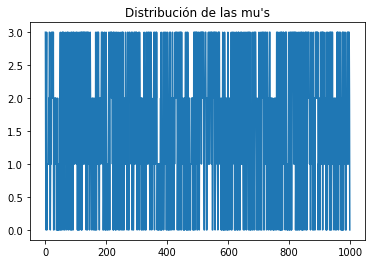

In [886]:
plt.plot(chosen_mus)
plt.title("Distribución de las mu's")

Text(0.5, 1.0, "Distribución de las i's")

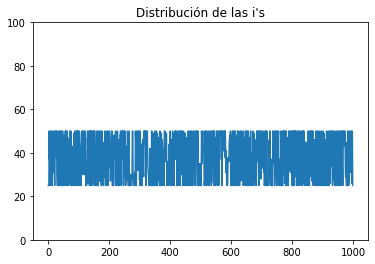

In [889]:
plt.plot([fun_i(P3,P4,np.random.rand(),fun_mu(P3,np.random.rand())) for i in range(1000)])
plt.ylim(0,100)
plt.title("Distribución de las i's")

Text(0.5, 1.0, "Distribución de las j's")

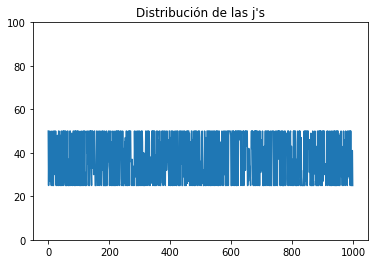

In [890]:
plt.plot([fun_j(P3,P5,np.random.rand(),fun_mu(P3,np.random.rand())) for i in range(1000)])
plt.ylim(0,100)
plt.title("Distribución de las j's")

### Actualizacion de la matriz de concentracion

In [978]:
def fun_act_dif(X, mu, i, j):
    if mu == 0:
        X[i,j] = X[i,j] - 1
        X[i - 1,j] = X[i - 1,j] + 1
    # Difusion hacia abajo    
    elif mu == 1:
        X[i,j] = X[i,j] - 1
        X[i + 1,j] = X[i + 1,j] + 1
    # Difusion hacia la izquierda
    elif mu == 2:
        X[i,j] = X[i,j] - 1
        X[i,j - 1] = X[i,j - 1] + 1
    # Difusion hacia la derecha
    elif mu == 3:
        X[i,j] = X[i,j] - 1
        X[i,j + 1] = X[i,j + 1] + 1
    return X

In [1006]:
def paso_montecarlo(X, a, t, P2, P3, d):
    
    r1 = np.random.rand()
    r2 = np.random.rand()
    r3 = np.random.rand()
    r4 = np.random.rand()
    
    
    # Calculo del peso universal a0
    
    a0 = fun_a0(a, d)
    
    #Calculo del intervalo tau
    
    
    tau = (1./a0)*np.log(1/r1)
    
    #Actualizamos el tiempo
                
    t = t + tau
    
    
    # Seleccion del procesos de reaccion-difusion
    
    mu = fun_mu(P3,r2)
    
        # Aqui se tienen que calcular las probabilidades P4 y P5
    
    for i in range(1,d + 1):
        suma_j = 0
        for j in range(1,d + 1):
            suma_j = suma_j + P2[mu,i,j]
        P4[i] = suma_j
        
    # Seleccion del renglon de ocurrencia
        
    i = fun_i(P3,P4,r3,mu)
    
    
    
    # Seleccion de la columna de ocurrencia
    
    j = fun_j(P4,r4,mu,i)
    
    #print('tau',format(tau, '.4f'),'mu',mu,'i',i,'j',j)
    
    #print('X[i,j]',X[i][j], 'X[i - 1,j]',X[i - 1][j], 'X[i + 1,j]',X[i + 1][j],#
    #      'X[i,j - 1]',X[i][j - 1], 'X[i,j + 1]',X[i][j + 1], 'a(mu,i,j)',a[mu][i][j],#
    #      'P2[mu][i][j]',P2[mu][i][j],'P3[mu]',P3[mu], 'P4[mu][i]',P4[i])
    
    # Actualizamos el vector de concentracion de acuerdo con el proceso elegido

    X = fun_act_dif(X, mu, i, j)
    
    #print('X[i,j]',X[i][j])
    
    # Actualizamos las condiciones de contorno si se actualizo algun punto de la frontera
    
    if i == 1 | i == 100 | j == 1 | j == 100:
        X = func_act_CC(X)

        
    # Actualizamos las as de acuerdo al nuevo vector X de concentracion
    
    a = actualizacion_as(a, X, d)
    
    # Actualizamos el peso universal a0
    
    a0 = fun_a0(a, d)
    
    
    # Actualizamos las Ps
    
    P2, P3 = act_probs(a,a0,P2,P3, d)
    

    
    return t, X, a, P2, P3

### Tests

In [963]:
X0 = np.zeros((102,102))

In [964]:
X0

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [965]:
for i in range(25,51):
    for j in range(25,51):
        X0[i][j] = 40

In [966]:
def func_act_CC(X0, d):
    for j in range(1,d + 1):
        X0[0][j] = X0[d][j]
        X0[d + 1][j] = X0[1][j]
        X0[j][0] = X0[j][d]
        X0[j][d + 1] = X0[j][1]
    return X0

In [967]:
X0 = func_act_CC(X0, 100)

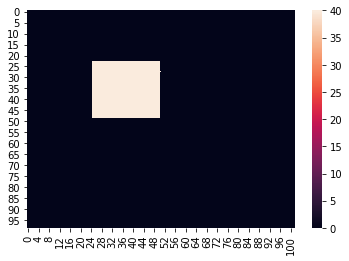

In [968]:
sns.heatmap(X0[1:101][1:101])

In [970]:
X0.shape

(102, 102)

In [923]:
a = np.zeros((4,102,102))

In [924]:
def actualizacion_as(a, X, d):
    for i in range(1,d + 1):
        for j in range(1,d + 1):
            a[0][i][j] =  D*(X[i][j] - X[i - 1][j])
            if a[0][i][j] < 0:
                a[0][i][j] = 0
            a[1][i][j] =  D*(X[i][j] - X[i + 1][j])
            if a[1][i][j] < 0:
                a[1][i][j] = 0
            a[2][i][j] =  D*(X[i][j] - X[i][j - 1])
            if a[2][i][j] < 0:
                a[2][i][j] = 0
            a[3][i][j] =  D*(X[i][j] - X[i][j + 1])
            if a[3][i][j] < 0:
                a[3][i][j] = 0
    return a

In [925]:
a = actualizacion_as(a,X0, 100)

In [926]:
a0 = fun_a0(a, 100)

In [927]:
P2 = np.zeros((4,102,102))
P3 = np.zeros((4))
P4 = np.zeros((4,102))
P5 = np.zeros((4,102))

In [930]:
P2, P3, P4, P5 = act_probs(a,a0,P2,P3,P4,P5,100)

In [931]:
P3

array([0.25, 0.25, 0.25, 0.25])

In [863]:
r1 = np.random.rand()
r2 = np.random.rand()
r3 = np.random.rand()
r4 = np.random.rand()

mu = fun_mu(P3,r2)
    
#Calculo del renglon

i = fun_i(P3,P4,r3,mu)

#Calculo de la columna

j = fun_j(P3,P5,r4,mu)

In [864]:
mu,i,j

(0, 25, 33)

#### Está mal actualizada $P_3(\mu|\tau)$ porque $a(\mu,i,j)$ no estaba operando bien

In [932]:
for i in range(20,56):
    print(P2[3][i][50])

0.0
0.0
0.0
0.0
0.0
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.0
0.0
0.0
0.0
0.0


#### Is it $a(\mu,i,j)$ well calculated?

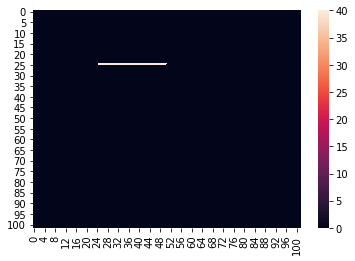

In [933]:
sns.heatmap(a[0][:][:])

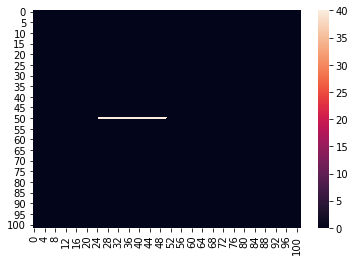

In [934]:
sns.heatmap(a[1][:][:])

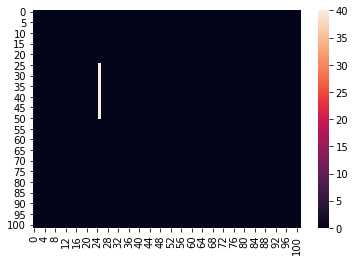

In [935]:
sns.heatmap(a[2][:][:])

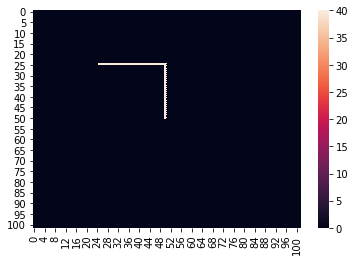

In [443]:
sns.heatmap(a[3][:][:])

#### Is not!!!

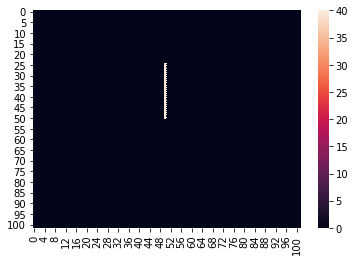

In [936]:
sns.heatmap(a[3][:][:])

In [937]:
P2[0][25][26]

0.009615384615384616

#### $P_2(\mu | \tau)$ is well calculated...is it!?

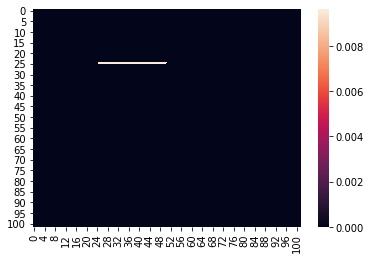

In [938]:
sns.heatmap(P2[0][:][:])

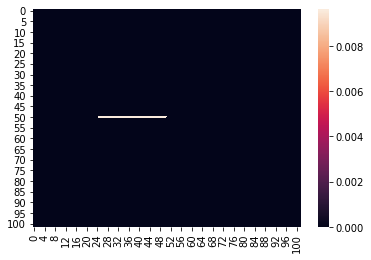

In [939]:
sns.heatmap(P2[1][:][:])

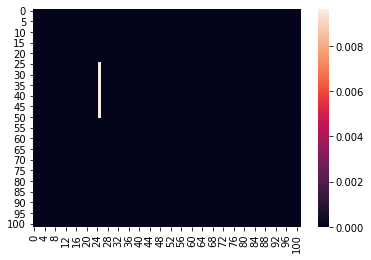

In [940]:
sns.heatmap(P2[2][:][:])

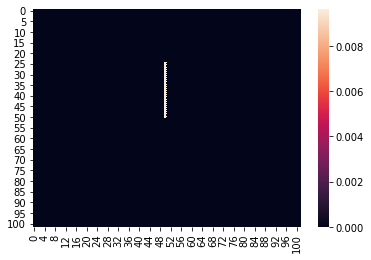

In [941]:
sns.heatmap(P2[3][:][:])

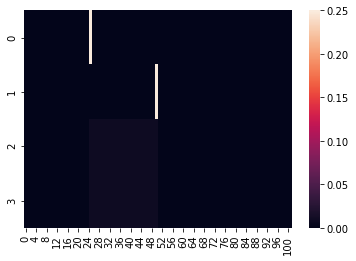

In [942]:
sns.heatmap(P4)

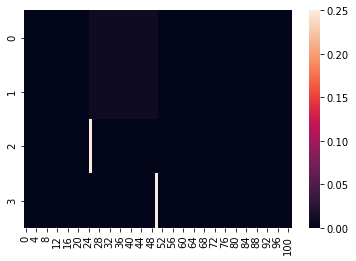

In [943]:
sns.heatmap(P5)

In [794]:
import time

In [791]:
X0 = X

## Simulación

In [1012]:
def nombre(s):
    diferencia = 4 - len(str(s))
    ceros = '' 
    for i in range(diferencia):
        ceros = ceros + '0'
    variable = ceros + str(s)
    return variable

In [1008]:
!pwd

/Users/adrianovaldesgomez/Documents/Adriano_Programming


In [1009]:
%mkdir "Gillespie_Sim_dif_00"

In [1010]:
%cd Gillespie_Sim_dif_00/

/Users/adrianovaldesgomez/Documents/Adriano_Programming/Gillespie_Sim_dif_00


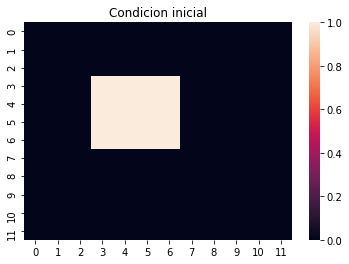

In [ ]:
start_time = time.time()

N_pasos = 3000


d = 10

# Creamos una condicion inicial; una distribucion de particulas inicial

X0 = np.zeros((d + 2, d + 2))

for i in range(3,7):
    for j in range(3,7):
        X0[i][j] = 1


# Replicamos las condiciones iniciales en el borde

X0 = func_act_CC(X0, d)

# Visualizamos la conddicion inicial

sns.heatmap(X0)
plt.title("Condicion inicial")
plt.savefig('Gillespie_Dif_{}.png'.format(nombre(0)))
plt.show()

# Iniciamos los vetores para las propensiones y probabilidades condicionadas

a = np.zeros((4,102,102))
P2 = np.zeros((4,102,102))
P3 = np.zeros((4))
P4 = np.zeros((102))
#P5 = np.zeros((4,102))

# Iniciamos el tiempo

t = 0

# Calculamos las propensiones

a = actualizacion_as(a,X0, d)

# Lista para registrar los momentos de actualizacion

tiempos = [0]

# Calculo de las probabilidades iniciales

P2, P3 = act_probs(a,a0,P2,P3, d)


# Bucle Principal Monte Carlo

for i in range(0,N_pasos):
    t, X0, a, P2, P3 = paso_montecarlo(X0, a, t, P2, P3, d)
    tiempos.append(t)
    fig = plt.figure()
    sns.heatmap(X0)
    fig.savefig('Gillespie_Dif_{}.png'.format(nombre(i+1)))
    plt.close()
    #fig.show()
    
sns.heatmap(X0)
plt.title("Condicion final")
plt.show()

tiempo_Sim = (time.time() - start_time)/60.

print("- %s minutos de simulación -" % (tiempo_Sim))

In [1015]:
!mencoder "mf://*.png" -o Gillespie_Dif_01.mov -ovc lavc -lavcopts vcodec=msmpeg4v2:autoaspect:vbitrate=2160000:mbd=2:keyint=132:vqblur=1.0:cmp=2:subcmp=2:dia=2:o=mpv_flags=+mv0:last_pred=3 -fps 20;
                                        


MEncoder 1.3.0-4.2.1 (C) 2000-2016 MPlayer Team
224 audio & 451 video codecs

success: format: 16  data: 0x0 - 0x0
MF file format detected.
[mf] search expr: *.png
[mf] number of files: 462 (3696)
[demux_mf] file type was not set! trying 'type=png'...
VIDEO:  [MPNG]  0x0  24bpp  25.000 fps    0.0 kbps ( 0.0 kbyte/s)
[V] filefmt:16  fourcc:0x474E504D  size:0x0  fps:25.000  ftime:=0.0400
Input fps will be interpreted as 20.000 instead.
libavcodec version 57.24.102 (internal)
Opening video filter: [expand osd=1]
Expand: -1 x -1, -1 ; -1, osd: 1, aspect: 0.000000, round: 1
Opening video decoder: [ffmpeg] FFmpeg's libavcodec codec family
Selected video codec: [ffpng] vfm: ffmpeg (FFmpeg PNG)
Could not find matching colorspace - retrying with -vf scale...
Opening video filter: [scale]
Movie-Aspect is undefined - no prescaling applied.
[swscaler @ 0x10ff7c410]bicubic scaler, from rgba to yuv420p using MMXEXT
videocodec: libavcodec (432x288 fourcc=3234504d [MP42])
[VE_LAVC] High quality encodi

Pos:   2.0s     40f ( 8%)  0.00fps Trem:   0min   0mb  A-V:0.000 [131:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:   2.0s     41f ( 8%)  0.00fps Trem:   0min   0mb  A-V:0.000 [129:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:   2.1s     42f ( 9%)  0.00fps Trem:   0min   0mb  A-V:0.000 [129:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:   2.1s     43f ( 9%)  0.00fps Trem:   0min   0mb  A-V:0.000 [128:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:   2.2s     44f ( 9%)  0.00fps Trem:   0min   0mb  A-V:0.000 [126:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:   2.2s     45f ( 9%)  0.00fps Trem:   0min   0mb  A-V:0.000 [126:0]
[msmpeg

Pos:   4.2s     85f (18%)  0.00fps Trem:   0min   0mb  A-V:0.000 [103:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:   4.3s     86f (18%)  0.00fps Trem:   0min   0mb  A-V:0.000 [103:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:   4.3s     87f (18%)  0.00fps Trem:   0min   0mb  A-V:0.000 [102:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:   4.4s     88f (19%)  0.00fps Trem:   0min   0mb  A-V:0.000 [102:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:   4.5s     89f (19%)  0.00fps Trem:   0min   0mb  A-V:0.000 [101:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:   4.5s     90f (19%)  0.00fps Trem:   0min   0mb  A-V:0.000 [101:0]
[msmpeg

Pos:   6.8s    137f (29%)  0.00fps Trem:   0min   0mb  A-V:0.000 [108:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:   6.9s    138f (29%)  0.00fps Trem:   0min   0mb  A-V:0.000 [108:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:   7.0s    139f (30%)  0.00fps Trem:   0min   0mb  A-V:0.000 [107:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:   7.0s    140f (30%)  0.00fps Trem:   0min   0mb  A-V:0.000 [107:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:   7.0s    141f (30%)  0.00fps Trem:   0min   0mb  A-V:0.000 [107:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:   7.1s    142f (30%)  0.00fps Trem:   0min   0mb  A-V:0.000 [107:0]
[msmpeg

Pos:   9.4s    188f (40%) 149.56fps Trem:   0min   0mb  A-V:0.000 [100:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:   9.4s    189f (40%) 149.53fps Trem:   0min   0mb  A-V:0.000 [101:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:   9.5s    190f (41%) 149.61fps Trem:   0min   0mb  A-V:0.000 [100:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:   9.6s    191f (41%) 149.69fps Trem:   0min   0mb  A-V:0.000 [100:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:   9.6s    192f (41%) 149.53fps Trem:   0min   0mb  A-V:0.000 [100:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:   9.7s    193f (41%) 149.73fps Trem:   0min   0mb  A-V:0.000 [100:0]
[

Pos:  11.8s    235f (50%) 149.78fps Trem:   0min   0mb  A-V:0.000 [96:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:  11.8s    236f (51%) 149.75fps Trem:   0min   0mb  A-V:0.000 [96:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:  11.8s    237f (51%) 149.72fps Trem:   0min   0mb  A-V:0.000 [96:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:  11.9s    238f (51%) 149.87fps Trem:   0min   0mb  A-V:0.000 [95:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:  11.9s    239f (51%) 149.84fps Trem:   0min   0mb  A-V:0.000 [96:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:  12.0s    240f (52%) 149.91fps Trem:   0min   0mb  A-V:0.000 [95:0]
[msmpeg

Pos:  14.4s    288f (62%) 153.60fps Trem:   0min   0mb  A-V:0.000 [100:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:  14.4s    289f (62%) 153.64fps Trem:   0min   0mb  A-V:0.000 [100:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:  14.5s    290f (62%) 153.52fps Trem:   0min   0mb  A-V:0.000 [100:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:  14.6s    291f (63%) 153.56fps Trem:   0min   0mb  A-V:0.000 [100:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:  14.6s    292f (63%) 153.52fps Trem:   0min   0mb  A-V:0.000 [100:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:  14.7s    293f (63%) 153.56fps Trem:   0min   0mb  A-V:0.000 [100:0]
[

Pos:  16.8s    335f (72%) 153.04fps Trem:   0min   0mb  A-V:0.000 [97:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:  16.8s    336f (72%) 153.01fps Trem:   0min   0mb  A-V:0.000 [97:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:  16.9s    337f (73%) 153.04fps Trem:   0min   0mb  A-V:0.000 [97:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:  16.9s    338f (73%) 153.08fps Trem:   0min   0mb  A-V:0.000 [97:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:  16.9s    339f (73%) 153.19fps Trem:   0min   0mb  A-V:0.000 [97:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:  17.0s    340f (73%) 153.22fps Trem:   0min   0mb  A-V:0.000 [96:0]
[msmpeg

Pos:  19.1s    382f (82%) 152.74fps Trem:   0min   0mb  A-V:0.000 [94:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:  19.1s    383f (83%) 152.71fps Trem:   0min   0mb  A-V:0.000 [94:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:  19.2s    384f (83%) 152.81fps Trem:   0min   0mb  A-V:0.000 [94:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:  19.2s    385f (83%) 152.84fps Trem:   0min   0mb  A-V:0.000 [94:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:  19.3s    386f (83%) 152.87fps Trem:   0min   0mb  A-V:0.000 [94:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:  19.4s    387f (83%) 152.84fps Trem:   0min   0mb  A-V:0.000 [94:0]
[msmpeg

Pos:  21.4s    428f (92%) 152.15fps Trem:   0min   0mb  A-V:0.000 [98:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:  21.4s    429f (93%) 152.07fps Trem:   0min   0mb  A-V:0.000 [98:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:  21.5s    430f (93%) 152.00fps Trem:   0min   0mb  A-V:0.000 [98:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:  21.6s    431f (93%) 151.87fps Trem:   0min   0mb  A-V:0.000 [98:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:  21.6s    432f (93%) 151.95fps Trem:   0min   0mb  A-V:0.000 [98:0]
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10ff62fe0]AVFrame.width or height is not set
Pos:  21.6s    433f (93%) 151.93fps Trem:   0min   0mb  A-V:0.000 [98:0]
[msmpeg

### Una reverenda mamada que haya cantidades negativas!!!!

Observaciones:
 - Está eligiendo regiones donde no hay partículas
 - Sin embargo, esto no tiene que ver con el cálculo de las $a(\mu,i,j)$, puesto que éstas son nulas en estos puntos
 - Todo indica que se debe a cómo se elige el punto donde se actualizan o el proceso, está eligiendo procesos de probabilidad nula!
 - Tiene que ser con la función que regresa las $mu$, $i$'s y $j$'s!!!
 - Otra pendajada inadmisible es que se pueden acumular particulas en una celda que superen la mayor concentracion máxima inicial!!!

In [902]:
tiempos

[0,
 0.022782939057878905,
 0.02610734412882857,
 0.048790656058410486,
 0.05771995365733049,
 0.05995416170285268,
 0.07688927362413511,
 0.09792596082899703,
 0.10064685583037497,
 0.10404976320464035,
 0.11157473891397447,
 0.11502195889833153,
 0.1197911972663537,
 0.12623550920730012,
 0.1297562360642434,
 0.13139343479445117,
 0.134924822172062,
 0.135850289238767,
 0.1359292925957475,
 0.1390414233509816,
 0.14343814691700968,
 0.14419596259873646,
 0.14493522209833276,
 0.14637190048680093,
 0.15072595141180445,
 0.1555651467744636,
 0.15729701225676557,
 0.1577887476805447,
 0.1585282839226886,
 0.1671757133157456,
 0.17313668989253111,
 0.1788557922846567,
 0.18104822388124395,
 0.18634442204578164,
 0.1933080349416896,
 0.19494516780948318,
 0.19573634084666922,
 0.19602582663045978,
 0.19953661279231316,
 0.21106746884781957,
 0.21500883291801848,
 0.21805031390903748,
 0.22207368125837582,
 0.24101787380098796,
 0.2412863888742947,
 0.24533605437751957,
 0.2544760208826429

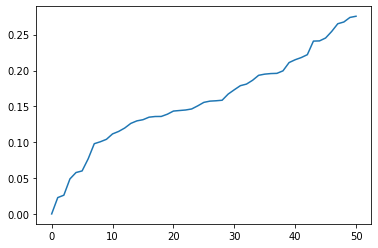

In [903]:
plt.plot(tiempos)

### Pruebas

In [346]:
def actualizacion_as(a, X):
    for i in range(1,101):
        for j in range(1,101):
            a[0][i][j] =  D*(X[i][j] - X[i - 1][j])
            if a[0][i][j] < 0:
                a[0][i][j] = 0
            a[1][i][j] =  D*(X[i][j] - X[i + 1][j])
            if a[1][i][j] < 0:
                a[1][i][j] = 0
            a[2][i][j] =  D*(X[i][j] - X[i][j - 1])
            if a[2][i][j] < 0:
                a[2][i][j] = 0
            a[3][i][j] =  D*(X[i][j] - X[i - 1][j + 1])
            if a[3][i][j] < 0:
                a[3][i][j] = 0
            print(i,j)
    return a

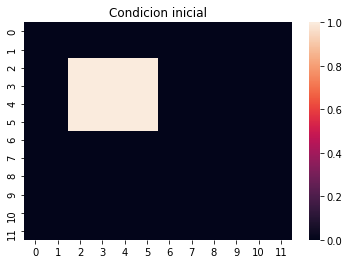

In [973]:
N_pasos = 20


d = 10

# Creamos una condicion inicial; una distribucion de particulas inicial

X0 = np.zeros((d + 2, d + 2))

for i in range(2,6):
    for j in range(2,6):
        X0[i][j] = 1


# Replicamos las condiciones iniciales en el borde

X0 = func_act_CC(X0, d)

# Visualizamos la conddicion inicial

sns.heatmap(X0)
plt.title("Condicion inicial")
plt.show()


In [972]:
X[0][0]

0.0